In [1]:
!pip install numpy
!pip install gym

import numpy as np #for our Qtable
import gym #for our cartpole Environment
import random #to generate random numbers
import pandas

#code for rendering gui
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install pyglet==1.4.0
!apt-get install x11-utils

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

env = gym.make("CartPole-v1")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (731 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 146364 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 784 kB of 

In [2]:
action_size = env.action_space.n
state_size = env.observation_space.shape[0]
print(env.action_space,env.observation_space)
print(action_size, state_size)

Discrete(2) Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
2 4


In [3]:
total_episodes = 10       # Total episodes
learning_rate = 0.2          # Learning rate
max_steps = 20               # Max steps per episode
gamma = 0.95                 # Discounting rate

# Exploration parameters
epsilon = 0.2                 # Exploration rate
max_epsilon = 0.2             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

#discreization parameters
n_bins = 8
n_bins_angle = 10
# Number of states is huge so in order to simplify the situation
# we discretize the space to: 10 ** number_of_features
cart_position_bins = pandas.cut([-2.4, 2.4], bins=n_bins, retbins=True)[1][1:-1]
pole_angle_bins = pandas.cut([-2, 2], bins=n_bins_angle, retbins=True)[1][1:-1]
cart_velocity_bins = pandas.cut([-1, 1], bins=n_bins, retbins=True)[1][1:-1]
angle_rate_bins = pandas.cut([-3.5, 3.5], bins=n_bins_angle, retbins=True)[1][1:-1]

In [4]:
def to_bin(value, bins):
    return np.digitize(x=[value], bins=bins)[0]

In [5]:
def build_state(features):
    
    return int("".join(map(lambda feature: str(int(feature)), features)))



In [6]:
def getQvalue(state, action):
  return qtable.get((state, action), 0.0)

In [7]:
def getMaxQ(state):
  q = [getQvalue(state, a) for a in range(action_size)]
  maxQ = max(q)
  return  maxQ, q.index(maxQ)

[10.0, 13.0, 11.0, 10.0, 20.0, 11.0, 10.0, 10.0, 12.0, 10.0] 20.0
Score over time: 11.7


array([ 0.02175785, -0.01651906, -0.00972793, -0.00956134])

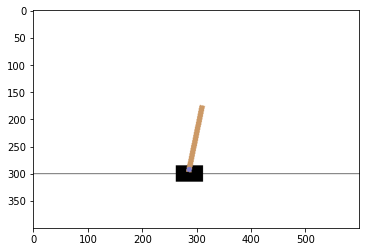

In [8]:
qtable = {}

#training the model for total_episodes iterations

# List of rewards
rewards = []

# For life or until learning is stopped
for episode in range(total_episodes): #20,000 episodes
    # Reset the environment
    cart_position, cart_velocity, pole_angle,angle_rate_of_change = env.reset()
   
    state = build_state([to_bin(cart_position, cart_position_bins),
                         to_bin(pole_angle, pole_angle_bins),
                         to_bin(cart_velocity, cart_velocity_bins),
                         to_bin(angle_rate_of_change, angle_rate_bins)])
    step = 0
    done = False
    total_rewards = 0
    #-----display
    #prev_screen = env.render(mode='rgb_array')
    #plt.imshow(prev_screen)
    for step in range(max_steps): #every episode can have a maximum of 99 time steps
        # Choose an action a in the current world state (s)
        ## First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        screen = env.render(mode='rgb_array')
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
       
        
        ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon: #select an action with the maximum q-value
            maxqval, action = getMaxQ(state)
            print(exp_exp_tradeoff, "action", action)

        # Else doing a random choice --> exploration
        else:
            action = env.action_space.sample()
            print("action random", action)
        #print(action)
        
        # Take the action (a) and observe the outcome state(s') and reward (r)
        observation, reward, done, info = env.step(action)

        cart_position, pole_angle, cart_velocity, angle_rate_of_change = observation
        new_state = build_state([to_bin(cart_position, cart_position_bins),
                          to_bin(pole_angle, pole_angle_bins),
                          to_bin(cart_velocity, cart_velocity_bins),
                          to_bin(angle_rate_of_change, angle_rate_bins)])

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        maxqval, action = getMaxQ(new_state)
        qtable[(state, action)] = getQvalue(state, action) + learning_rate * (reward + gamma *maxqval - getQvalue(state, action))
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state
        
        # If done (if we're dead) : finish episode
        if done == True: 
            break
        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)
    ipythondisplay.clear_output(wait=True)
print(rewards,max(rewards))
print ("Score over time: " +  str(sum(rewards)/total_episodes))


#testing the agent
env.reset()



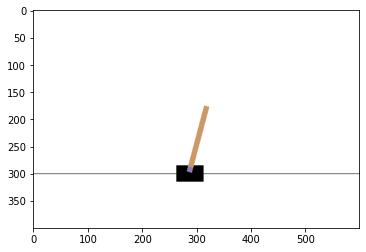

In [9]:
for episode in range(5):
    cart_position, pole_angle, cart_velocity, angle_rate_of_change = env.reset()
   
    state = build_state([to_bin(cart_position, cart_position_bins),
                         to_bin(pole_angle, pole_angle_bins),
                         to_bin(cart_velocity, cart_velocity_bins),
                         to_bin(angle_rate_of_change, angle_rate_bins)])
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)
    for step in range(max_steps):
        
        # Take the action (index) that have the maximum expected future reward given that state
        maxqval, action = getMaxQ(state)
        
        observation, reward, done, info = env.step(action)
        cart_position, pole_angle, cart_velocity, angle_rate_of_change = observation
        new_state = build_state([to_bin(cart_position, cart_position_bins),
                          to_bin(pole_angle, pole_angle_bins),
                          to_bin(cart_velocity, cart_velocity_bins),
                          to_bin(angle_rate_of_change, angle_rate_bins)])
        screen = env.render(mode='rgb_array')
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        if done:
          break
        state = new_state
    ipythondisplay.clear_output(wait=True)
env.close()